## LightHouse Data Challenge
> Candidate: Kimberly Goth
    

In [18]:
import pandas as pd
import numpy as np
import graphviz
import matplotlib.pyplot as plt
import os
import regex as re
import seaborn as sns
from sklearn import tree
from sklearn.metrics import classification_report
import statistics
from statsmodels.stats.outliers_influence import variance_inflation_factor


#### Reading in all of the gzip files

In [19]:

files = [i for i in os.listdir('..\data') if 'csv.gz' in i]
data = pd.DataFrame()

for file in files:
    file_data = pd.read_csv('..\data\\{}'.format(file), compression='gzip')
    file_data['year_quarter'] = file[:6]
    data = pd.concat([data, file_data])
data.head()
len(data)

438991

#### encoding the target variable into binary (1=No default, 0=Default)

In [20]:
print(data['loan_status'].value_counts())

# going to use loan_status as the target variable to determine which attributes/features are predictive of a loan not defaulting
loan_status_dict = {
    'Current': 1,
    'Fully Paid': 1,
    'Charged Off': 0,
    'Late (31-120 days)': 0,
    'In Grade Period': 0,
    'Late (16-30 days)': 0
}

data['no_default'] = data['loan_status'].map(lambda x: loan_status_dict.get(x))
data['no_default'].value_counts()

Current               251552
Fully Paid            132055
Charged Off            40902
Late (31-120 days)      8209
In Grace Period         4016
Late (16-30 days)       2257
Name: loan_status, dtype: int64


1.0    383607
0.0     51368
Name: no_default, dtype: int64

#### checking loan volume by quarter

<AxesSubplot:xlabel='year_quarter', ylabel='Count'>

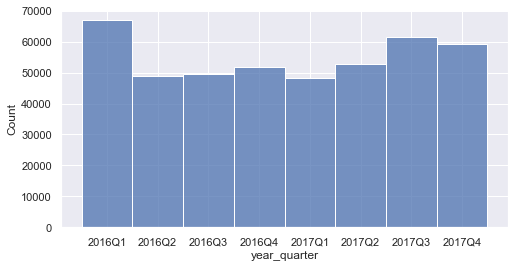

In [21]:
sns.set(rc={'figure.figsize':(8,4)})
sns.histplot(data=data, x='year_quarter')

#### reformatting and encoding some columns

In [22]:

def data_prep(df):
    # removing columns with 40% or more missing values
    missing_df = pd.DataFrame(data.isna().sum()/len(df), columns=['percent_missing'])
    missing_df = missing_df[missing_df['percent_missing']>=0.4]
    df.drop(columns=missing_df.index, inplace=True)


    df['revol_util_percentage'] = df['revol_util'].map(lambda x: float(str(x)[:-1]) if '%' in str(x) else x)
    df['application_type_ind'] = df['application_type'].map(lambda x: 1 if x=='Joint App' else 0)
    df['int_rate'] = df['int_rate'].map(lambda x: float(x[:-1]))


    home_ownership_dict = {
        'MORTGAGE': 1,
        'RENT': 2,
        'OWN': 3,
        'ANY': 4,
        'NONE': 5
    }

    df['home_ownership_encoded'] = df['home_ownership'].map(lambda x: home_ownership_dict.get(x))

    purpose_dict = {
        'debt_consolidation': 1,   
        'credit_card': 2,           
        'home_improvement': 3,      
        'other': 4,               
        'major_purchase': 5,         
        'medical': 6,                 
        'car': 7,             
        'small_business': 8,          
        'vacation': 9,                
        'moving': 10,                  
        'house': 11,                   
        'renewable_energy': 12,         
        'educational': 13,                
        'wedding': 14                    
    }


    df['purpose_encoded'] = df['purpose'].map(lambda x: purpose_dict.get(x))

    df['earliest_cr_line_year'] = df['earliest_cr_line'].map(lambda x: int(x[4:6]))
    df['term_binary_ind'] = df['term'].map(lambda x: 1 if '60 months' in x else 0)

    df.drop(columns=['application_type', 'revol_util', 'home_ownership', 'purpose',
                       'term', 'earliest_cr_line', 'emp_title', 'zip_code', 'addr_state', 'id',
                       'loan_status', ], inplace=True)
    
    return df

data = data_prep(data)

### Splitting data into train and test based on time.  Roughly a 70:30 split
> * Train includes data from 2016Q1 through 2017Q2
> * Test includes data from 2017Q3 through 2017Q4

In [23]:
train_df = data[data['year_quarter'].isin(['2016Q1', '2016Q2', '2016Q3', '2016Q4', '2017Q1', '2017Q2'])]

test_df = data[data['year_quarter'].isin(['2017Q3', '2017Q4'])]

print('train volume = {} and percentage = {}'.format(len(train_df), len(train_df)/len(data)))
print('test volume = {} and percentage = {}'.format(len(test_df), len(test_df)/len(data)))

train volume = 318317 and percentage = 0.7251105375736633
test volume = 120674 and percentage = 0.2748894624263368


#### applying imputation to columns with missing values

In [ ]:
def imputation(train, test):
    float_columns = train.loc[:, train.dtypes == float].columns
    for col in float_columns:
        mean_val = statistics.mean(train[col].dropna())
        train[col] = train[col].replace(np.nan, mean_val)
        test[col] = test[col].replace(np.nan, mean_val)
        
    mode_val = statistics.mode(train['emp_length'].dropna())
    train['emp_length'] = train['emp_length'].replace(np.nan, mode_val)
    train['emp_length_years'] = train['emp_length'].map(lambda x: int(x[:2]) if str(x)[0] != '<' else 0)
    test['emp_length'] = test['emp_length'].replace(np.nan, mode_val)
    
    test['emp_length_years'] = test['emp_length'].map(lambda x: int(x[:2]) if str(x)[0] != '<' else 0)
        
    train.drop(columns=['emp_length', 'year_quarter'], inplace=True)
    test.drop(columns=['emp_length', 'year_quarter'], inplace=True)
    return train, test 
    
train_df, test_df = imputation(train_df, test_df)

#### Looking to see which columns are highly correlated with target variable

In [25]:
corr_df = pd.DataFrame(train_df.corrwith(train_df["no_default"]), columns=['corr_w_target'])
corr_df.reset_index(inplace=True)
corr_df.rename(columns={'index': 'feature'}, inplace=True)
corr_df

,feature,corr_w_target
0,funded_amnt,-0.037361
1,int_rate,-0.223318
2,installment,-0.055247
3,annual_inc,0.032228
4,dti,-0.059901
5,delinq_2yrs,-0.014489
6,fico_range_high,0.112964
7,inq_last_6mths,-0.082179
8,open_acc,-0.018943
9,revol_bal,0.025793


#### Calculating Variance Inflation Factor (VIF) values for all of the features in the dataset to assess for multicollinearity.

In [26]:
# code source: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

vif_data = pd.DataFrame()

# removed features with very high VIF and then reran analysis iteratively.
column_list = [c for c in train_df.columns if c not in ('open_acc', 'fico_range_high', 'funded_amnt', 
                                                        'acc_open_past_24mths', 'pct_tl_nvr_dlq', 'num_sats',
                                                        'all_util', 'total_rev_hi_lim', 'bc_util', 'total_acc', 'total_bc_limit',
                                                        'revol_util_percentage', 'il_util', 'no_default')]
check = train_df[column_list]
vif_data["feature"] = check.columns
  

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(check.values, i)
                          for i in range(len(check.columns))]
  
vif_data

,feature,VIF
0,int_rate,11.832563
1,installment,4.872793
2,annual_inc,2.467516
3,dti,4.619305
4,delinq_2yrs,2.104993
5,inq_last_6mths,1.979285
6,revol_bal,2.621471
7,open_act_il,2.890183
8,open_il_24m,3.221662
9,open_rv_24m,5.609211


#### Selecting Features for Model
> Since there are no strong correlations between the features and the target variable, I am choosing to select features that have at least a 0.04 or greater correlation and have a VIF of <= 12.  Typically, a VIF value of 10 would indicate high collinearity, but I am selecting a value of 12 or less to bring in some additional features.

In [27]:
combined = pd.merge(corr_df, vif_data, on='feature', how='inner')
combined = combined[combined.apply(lambda x: abs(x['corr_w_target']) > 0.04 and x['VIF'] <=12, axis=1)]
combined['feature'].values
                          

array(['int_rate', 'installment', 'dti', 'inq_last_6mths', 'open_il_24m',
       'open_rv_24m', 'inq_last_12m', 'bc_open_to_buy', 'mort_acc',
       'mths_since_recent_bc', 'num_rev_tl_bal_gt_0',
       'num_tl_op_past_12m', 'percent_bc_gt_75', 'home_ownership_encoded',
       'term_binary_ind'], dtype=object)

#### Features selected to use for model

In [28]:
out = combined['feature'].values 

#### Creating the train_X, train_y and test_X, test_X for the model

In [29]:
train_X = train_df[out]
train_y = train_df['no_default'].map(int)

test_X = test_df[out]
test_y = test_df['no_default'].map(int)

#### Selected a simple decision tree as the first model for an easy to interpret model
> Normally, I would perform a grid search to find the best hyperparameters.  However, due to time constraints, I manually tried a few different hyperparameters.  Below is the best model from the manual search.

> The decision tree has a tendency to overfit the training data, so I increased the min_samples_split from (default=2) and max_depth (15).

In [83]:
clf = tree.DecisionTreeClassifier(class_weight='balanced', min_samples_split=3, max_depth=5, random_state=42)
clf = clf.fit(train_X, train_y)

#### Model performance on training dataset

In [84]:
y_true = train_y
y_pred = clf.predict(train_X)
target_names = ['Defaulted 0', 'No Default 1']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Defaulted 0       0.23      0.64      0.34     46322
No Default 1       0.91      0.64      0.75    271995

    accuracy                           0.64    318317
   macro avg       0.57      0.64      0.54    318317
weighted avg       0.81      0.64      0.69    318317



#### Performance on the Test dataset.
> Overall accuracy may not be the best metric to measure the success of the model.  Therefore, I am evaluating model performance based on a combination of recall and precision (F1-score) for loans that do not default.

In [85]:
y_true = test_y
y_pred = clf.predict(test_X)
target_names = ['Defaulted 0', 'No Default 1']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Defaulted 0       0.13      0.62      0.21      9062
No Default 1       0.95      0.65      0.77    111612

    accuracy                           0.65    120674
   macro avg       0.54      0.63      0.49    120674
weighted avg       0.89      0.65      0.73    120674



In [93]:
for f, i in zip(out, clf.feature_importances_):
    print(f, ":", i)

int_rate : 0.9134224742079927
installment : 0.00503277840470328
dti : 0.006650878937776933
inq_last_6mths : 0.0
open_il_24m : 0.0
open_rv_24m : 0.0354054063598533
inq_last_12m : 0.0
bc_open_to_buy : 0.004790644543249306
mort_acc : 0.0027530159353432076
mths_since_recent_bc : 0.0009445268765125599
num_rev_tl_bal_gt_0 : 0.0
num_tl_op_past_12m : 0.005015472476272554
percent_bc_gt_75 : 0.0
home_ownership_encoded : 0.02346629769169983
term_binary_ind : 0.0025185045665963766


#### Visualizing the decision tree model

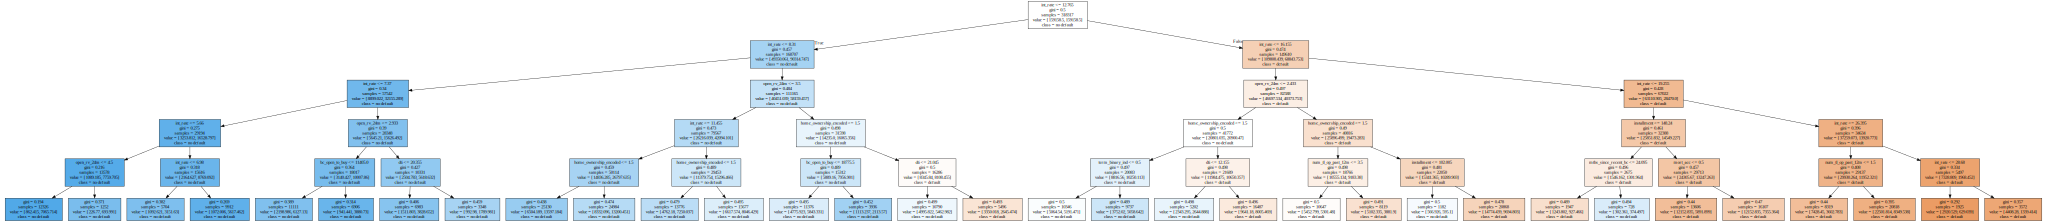

In [86]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=train_X.columns,  
                                class_names=['default', 'no default'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

#### The decision tree select int_rate as the most informative feature to split on:
> Overall, int_rates <= 12.765 tends to have higher rates of loans that do not default.  Higher int_rates may indicate higher risk for default.  Int_rate was split multiple times in the decision tree which may indicate that default rates differ across different levels of int_rate.


#### Instead of using a single decision tree, LGBM uses many weak decision trees.
> LGBM ensembles the trees' predictions into a smoother decision boundary.  LGBM also uses boosting which is like bagging, but puts weights one hard to predict instances so that they are more likely to be sampled for the next tree.  This could also be a culprit to over-fitting.

In [95]:
import lightgbm as lgb

model = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=0.1,random_state=42, class_weight='balanced', n_estimators=300, colsample_bytree=0.75)
model.fit(train_X,train_y,eval_set=[(test_X, test_y), (train_X, train_y)],
          verbose=20,eval_metric='logloss')

[20]	training's binary_logloss: 0.630015	valid_0's binary_logloss: 0.621677
[40]	training's binary_logloss: 0.622335	valid_0's binary_logloss: 0.599131
[60]	training's binary_logloss: 0.618767	valid_0's binary_logloss: 0.59445
[80]	training's binary_logloss: 0.61615	valid_0's binary_logloss: 0.591787
[100]	training's binary_logloss: 0.613578	valid_0's binary_logloss: 0.581433
[120]	training's binary_logloss: 0.611307	valid_0's binary_logloss: 0.574705
[140]	training's binary_logloss: 0.60927	valid_0's binary_logloss: 0.571925
[160]	training's binary_logloss: 0.607368	valid_0's binary_logloss: 0.567219
[180]	training's binary_logloss: 0.605323	valid_0's binary_logloss: 0.562775
[200]	training's binary_logloss: 0.603336	valid_0's binary_logloss: 0.559999
[220]	training's binary_logloss: 0.601634	valid_0's binary_logloss: 0.556839
[240]	training's binary_logloss: 0.59964	valid_0's binary_logloss: 0.552507
[260]	training's binary_logloss: 0.598006	valid_0's binary_logloss: 0.550078
[280]	t

LGBMClassifier(class_weight='balanced', colsample_bytree=0.75, n_estimators=300,
               random_state=42)

#### Results of LGBM on training data.

In [96]:
from sklearn.metrics import classification_report
y_true = train_y
y_pred = model.predict(train_X)
target_names = ['Defaulted 0', 'No Default 1']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Defaulted 0       0.26      0.70      0.37     46322
No Default 1       0.93      0.65      0.77    271995

    accuracy                           0.66    318317
   macro avg       0.59      0.68      0.57    318317
weighted avg       0.83      0.66      0.71    318317



#### Results of LGBM on test data

In [97]:
from sklearn.metrics import classification_report
y_true = test_y
y_pred = model.predict(test_X)
target_names = ['Defaulted 0', 'No Default 1']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Defaulted 0       0.14      0.52      0.22      9062
No Default 1       0.95      0.74      0.83    111612

    accuracy                           0.72    120674
   macro avg       0.55      0.63      0.53    120674
weighted avg       0.89      0.72      0.79    120674



#### The LGBM model performed better than the Decision tree on F1-score for No-Default  (Decision Tree F1 = 0.77 vs. LGBM F1 = 0.83)

In [ ]:
y_true = test_y
y_prob = model.predict_proba(test_X)
#test_X['prob_no_default'] = y_prob[:,1]
y_pred = model.predict(test_X)
test_X['y_pred'] = y_pred
test_X['y_prob'] = y_prob[:, 1]
test_X.head()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

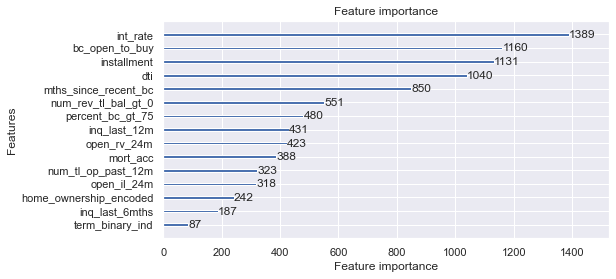

In [99]:
# code source: https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/

lgb.plot_importance(model)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

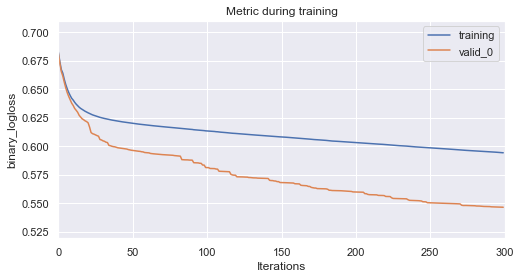

In [100]:
lgb.plot_metric(model)

In [101]:
import graphviz

<AxesSubplot:>

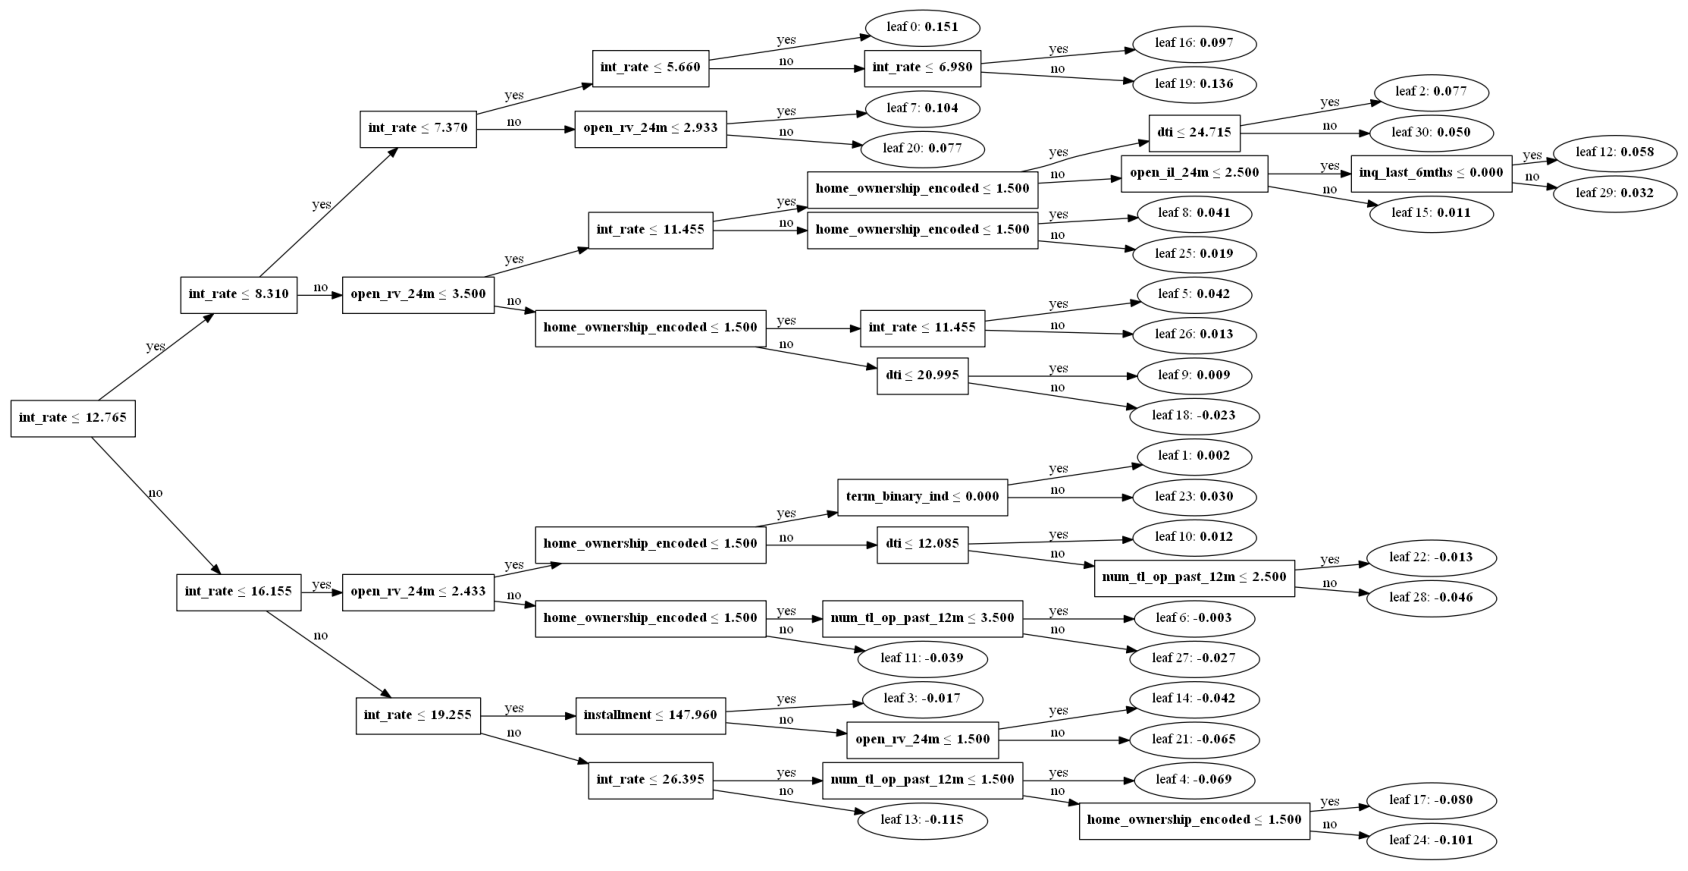

In [103]:
lgb.plot_tree(model,figsize=(30,40))

#### Using made up examples to see if the loan would be a good investment decision

In [106]:
fake_example_loans = pd.DataFrame(
    {
    'int_rate': [13.3, 5.2],
    'installment': [300, 40],
    'dti': [50.5, 26.7],
    'inq_last_6mths': [0, 2],
    'open_il_24m': [5, 7],
    'open_rv_24m': [5, 4],
    'inq_last_12m': [0, 1],
    'bc_open_to_buy': [70, 98],
    'mort_acc': [3, 1],
    'mths_since_recent_bc': [25, 12],
    'num_rev_tl_bal_gt_0': [10, 5],
    'num_tl_op_past_12m': [1, 0],
    'percent_bc_gt_75': [100.0, 85.3],
    'home_ownership_encoded': [0, 1],
    'term_binary_ind': [1, 0],
    }
)
fake_example_loans

,int_rate,installment,dti,inq_last_6mths,open_il_24m,open_rv_24m,inq_last_12m,bc_open_to_buy,mort_acc,mths_since_recent_bc,num_rev_tl_bal_gt_0,num_tl_op_past_12m,percent_bc_gt_75,home_ownership_encoded,term_binary_ind
0,13.3,300,50.5,0,5,5,0,70,3,25,10,1,100.0,0,1
1,5.2,40,26.7,2,7,4,1,98,1,12,5,0,85.3,1,0


#### Below is a function for investors to enter in features of loans to determine an investment decision

In [126]:
def investment_decision(loan_feature_example):
    pred = model.predict(loan_feature_example)
    prob = model.predict_proba(loan_feature_example)
    if pred == 1:
        print('Likely good investment opportunity with a {:.2%} probability of not defaulting'.format(prob[:,1][0]))
    else:
        print('Likely to default with a {:.2%} probability of defaulting'.format(prob[:,0][0]))
        
for i, row in fake_example_loans.iterrows():
    invest_decision(pd.DataFrame(fake_example_loans.iloc[i,:]).T)

Likely to default with a 67.22% probability of defaulting
Likely good investment opportunity with a 77.10% probability of not defaulting
